In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
from pylab import *

import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [2]:
rcParams = matplotlib.rcParams
params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
rcParams.update(params)

In [3]:
mf_filepath = "/home/tvas/data/moa-regression/small/results/dataset_2175_kin8nm_0.csv"
mf_df = pd.read_csv(mf_filepath)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f30d3bfab38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f30cb2c7240>]], dtype=object)

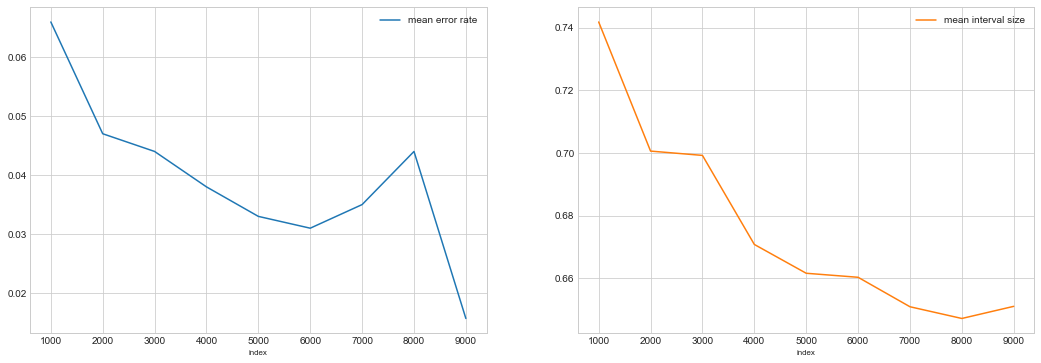

In [4]:
fig_scale = 6
mf_df.plot(subplots=True, x='index', layout=(1, 2), sharex=False, figsize=(fig_scale * 3, fig_scale))

In [5]:
qrf_filepath = "/home/tvas/data/moa-regression/small/results-MOA/dataset_2175_kin8nm_0.csv"
qrf_df = pd.read_csv(qrf_filepath)

In [6]:
qrf_df

,learning evaluation instances,evaluation time (cpu seconds),model cost (RAM-Hours),classified instances,mean error rate,mean interval size,model training instances,model serialized size (bytes)
0,1000.0,0.492016,2.172653e-07,1000.0,0.113,0.887515,1000.0,1706920.0
1,2000.0,0.925753,5.529583e-07,2000.0,0.062,0.860626,2000.0,2991704.0
2,3000.0,1.363382,1.083834e-06,3000.0,0.083,0.832675,3000.0,4689096.0
3,4000.0,1.777301,1.642086e-06,4000.0,0.086,0.817450,4000.0,5213360.0
4,5000.0,2.220763,2.476002e-06,5000.0,0.093,0.811741,5000.0,7268888.0
5,6000.0,2.732891,3.675542e-06,6000.0,0.061,0.804228,6000.0,9053960.0
6,7000.0,3.249624,4.964383e-06,7000.0,0.082,0.785976,7000.0,9641288.0
7,8000.0,3.793571,6.466896e-06,8000.0,0.084,0.785131,8000.0,10677360.0
8,8192.0,4.122827,7.418728e-06,8192.0,0.077,0.784530,8192.0,11174552.0


In [8]:
error_rate_df = mf_df[["index", "mean error rate"]]

In [14]:
error_rate_df.rename(columns={"mean error rate" : "MF"}, inplace=True)

In [15]:
error_rate_df["OnlineQRF"] = qrf_df["mean error rate"]
#error_rate_df

In [16]:
error_rate_df

,index,MF,OnlineQRF
0,1000,0.065934,0.113
1,2000,0.047000,0.062
2,3000,0.044000,0.083
3,4000,0.038000,0.086
4,5000,0.033000,0.093
5,6000,0.031000,0.061
6,7000,0.035000,0.082
7,8000,0.044000,0.084
8,9000,0.015707,0.077


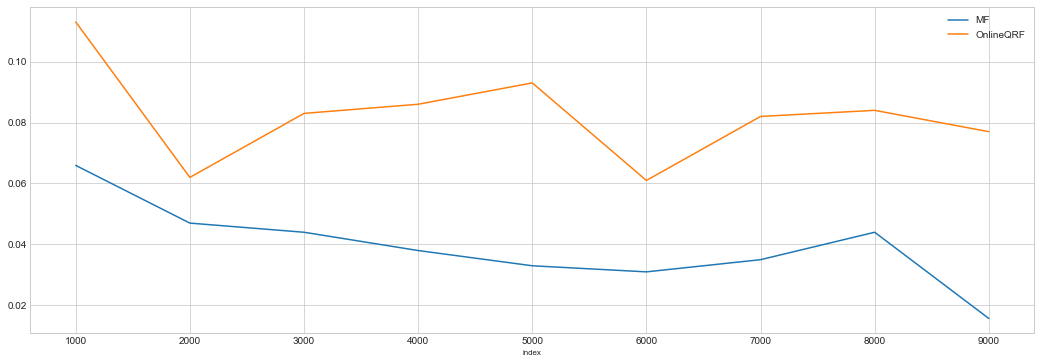

In [17]:
error_rate_df.plot(x='index', figsize=(fig_scale * 3, fig_scale))

### Error bars

In [18]:
from pathlib import Path
from collections import defaultdict

res_path = Path("/home/tvas/data/moa-regression/small/results-MOA/")

def gather_method_results(filepath):
    """Returns a dict from dataset name to a list of result dataframes"""
    res_path = Path(filepath)
    res = defaultdict(list)
    for res_file in res_path.glob("*.csv"):
        base_name = res_file.name[:-6]
        res[base_name].append(pd.read_csv(res_file))    
    return res

In [19]:
# Gather the results for each method
moa_results = gather_method_results("/home/tvas/data/moa-regression/small/results-MOA/")
skgarden_results = gather_method_results("/home/tvas/data/moa-regression/small/results/")

In [24]:
def gather_metric(results_dict, metric):
    """Returns a dict from dataset name to a df
    containing the measurements for the requested metric"""
    dataset_to_metric = {}
    for ds_name, df_list in results_dict.items():
        metric_df = pd.DataFrame()
        for inner_df in df_list:
            metric_df = metric_df.append(inner_df[metric])
        dataset_to_metric[ds_name] = metric_df
    return dataset_to_metric
    

In [25]:
# Gather the mean error rate results for each method 
# The resulting dicts map dataset name to a df containing the measurements for a specific metric
# for each experiment replicate, i.e. {ds_name: measurements_df}
moa_ds_to_mer = gather_metric(moa_results, "mean error rate")
skgarden_ds_to_mer = gather_metric(skgarden_results, "mean error rate")

In [26]:
# Map the measurements for each method to its name for easier plotting
# {method: {ds_name: measurements_df}}
method_mer_dict =  {"OnlineQRF": moa_ds_to_mer, "MF": skgarden_ds_to_mer}

In [44]:
def plot_metric(method_metric_dict, dataset_name, x_axis, metric_name):    
    """Plots and returns the aggregated statistics for a specific metric,
    for each method in the provided dict: {method: {ds_name: measurements_df}}"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('Instance', fontsize = 10)
    ax.set_ylabel(metric_name, fontsize = 10)
    method_to_mu_std = {}
    # Get the method name, and its measurements for all datasets
    for method, ds_metric_dict in method_metric_dict.items():
        # Get the measurements for the requested data, and calc their stats
        metric_df = ds_metric_dict[dataset_name]
        mu = metric_df.mean()
        std = metric_df.std()
        # Store the result
        method_to_mu_std[method] = (mu, std)
        # Plot the line for the method and dataset
        ax.errorbar(x_axis, mu, std, label=method)
    plt.legend()
    plt.show()
    return method_to_mu_std

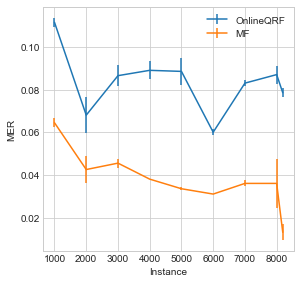

In [45]:
# Get the x axis range, and plot a specific dataset comparison.
ds = "dataset_2175_kin8nm"
x_axis = moa_results[ds][0]["learning evaluation instances"].astype(int)
method_to_stats = plot_metric(method_mer_dict, ds, x_axis, "MER")